# 1 Data wrangling<a id='1_Data_wrangling'></a>

## 1.1 Contents<a id='1.1_Contents'></a>
* [1 Data wrangling](#1_Data_wrangling)
    * [1.1 Contents](#1.1_Contents)
    * [1.2 Introduction](#1.2_Introduction)
        * [1.2.1 Problem Identification](#1.2.1_Problem_Identification)
    * [1.3 Imports](#1.3_Imports)
    * [1.4 User Defined Functions](#1.4_User_Defined_Functions)
    * [1.5 Sorting the Data](#1.5_Sorting_the_Data)
    * [1.6 Train Validation Split](#1.6_Train_validation)
    * [1.7 EDA](#1.7_Plot_Train)
    * [1.8 Data Augmentation](#1.8_data_augmentation)
    * [1.9 Summary](#1.9_Summary)  
    
    

## 1.2 Introduction<a id='1.2_Introduction'></a>

A Flower shop sells 10 different kinds of flowers such as Hibiscus, lilies and daisies. Customers buy these flowers and upload pictures to the Flower shop website. The Florist then takes these photos and manually labels each photo so that it can be added to the Customer Image Reviews database.

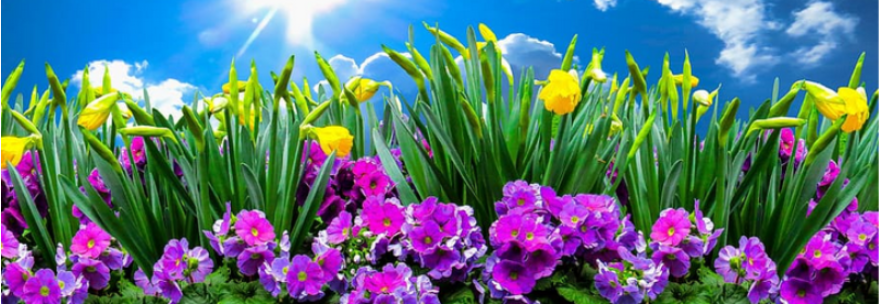

### 1.2.1 Problem Identification<a id='1.2.1_Problem_Identification'></a>

Currently, the florist manually classify flowers based on the image and assign the photos a label. The business objective of the flower shop is to build an automated image classifier so that the florist does not have to spend time manually classifying customer photos. Not only will this classifier save the florist time manually classifying these images, but also help her utilize the time saved to more useful tasks such as watering the plants or decorating new flower bouquets. 

Due to high demand of the flowers and low labor shortage, the business owner has outsourced this task to a consulting firm.

In order to accomplish this task, the consulting company has chosen a comprehensive flower dataset consisting of 10 different flower categories to correctly classify these flowers. The third party data consists of all the flowers that the florist sells.
This dataset can be found at the link here: https://www.kaggle.com/aksha05/flower-image-dataset

## 1.3 Imports<a id='1.3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
import re
import pathlib
import glob
import shutil
import os

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom

## 1.4 User Defined Functions<a id='1.4_User_Defined_Functions'></a>

In [2]:
def listDir(dir):
    """This function lists the names of all the files in the directory"""
    fileNamesList = []
    fileNames = os.listdir(dir)
    for fileName in fileNames:
        fileNamesList.append(fileName)
    return fileNamesList

def get_class_names(s):
    """This function helps parse the class names from the JPEG Names"""
    result = re.sub(r'.jpg', '', s, 1)
    result = re.sub(r'\d+', '', result, 1)
    result = result[:-1]
    return result

## 1.5 Sorting the Data<a id='1.5_Sorting_the_Data'></a>

In [3]:
#Raw Data Path
RAW_FOLDER_PATH = 'flowers/'

In [4]:
#Reading all .jpgs file names into a List
all_image_names = pd.Series(listDir(RAW_FOLDER_PATH))

In [5]:
#Getting the unique class names
folders = np.array(all_image_names.apply(lambda x: get_class_names(x)).unique()) 

In [6]:
#Printing the different Class names of the flowers dataset
folders

array(['bougainvillea', 'daisies', 'gardenias', 'garden_roses',
       'hibiscus', 'hydrangeas', 'lilies', 'orchids', 'peonies', 'tulip'],
      dtype=object)

In [7]:
#Creating a parent directory to save the Preprocessed data
pathlib.Path('preprocessed_data').mkdir(parents=True, exist_ok = True)

In [8]:
#Creating folders to save results. If this breaks,create manually
PREPROCESS_FOLDER_PATH = 'preprocessed_data/'

for fpath in folders:                 
    pathlib.Path(PREPROCESS_FOLDER_PATH + fpath).mkdir(parents=True, exist_ok=True) 

In [9]:
#Copying the Raw images and saving them to a individual directories
for flower_name in folders:
    for jpgfile in glob.iglob(os.path.join(RAW_FOLDER_PATH, flower_name + "*.jpg")):
        shutil.copy(jpgfile, PREPROCESS_FOLDER_PATH + flower_name)

## 1.6 Train Validation Split<a id='1.6_Train_validation'></a>

In [10]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
train_dataset = image_dataset_from_directory(PREPROCESS_FOLDER_PATH,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(PREPROCESS_FOLDER_PATH,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 733 files belonging to 10 classes.
Using 587 files for training.
Found 733 files belonging to 10 classes.
Using 146 files for validation.


There are **733** images in total. Out of the 733, 80% have been used for training and the other 20% of validation

In [11]:
#Extracting Classnames from the train dataset
class_names = np.array(train_dataset.class_names)
print(class_names)

['bougainvillea' 'daisies' 'garden_roses' 'gardenias' 'hibiscus'
 'hydrangeas' 'lilies' 'orchids' 'peonies' 'tulip']


## 1.7 Plot Images and Labels from the Train Dataset<a id='1.7_Plot_Train'></a>

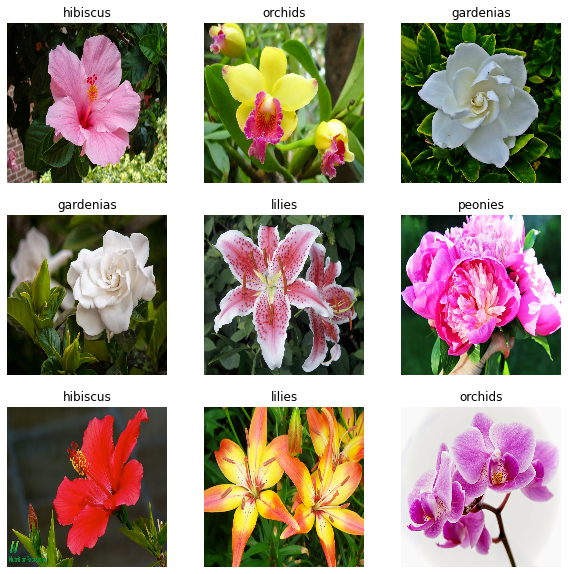

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
#Running an Optimizing Algorithm to find a good allocation of the CPU
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

## 1.8 Data Augmentation<a id='1.8_data_augmentation'></a>

In [14]:
#Data Augmentation
def data_augmenter():
    '''
    Create a Sequential model composed of 3 layers
    Random Flip
    Random Rotate
    Random Zoom
    
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.2))
    data_augmentation.add(RandomZoom(0.5, 0.2))
    
    return data_augmentation

In [15]:
#Initialize the augmenter
augmenter = data_augmenter()

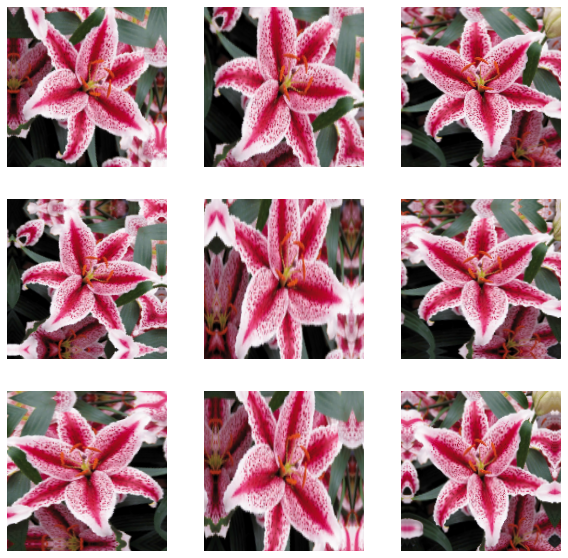

In [16]:
#Plot the augmented data
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

## 1.9 Summary<a id='1.9_Summary'></a>

The Data Wrangling for Image Processing comprises of the following steps:
    1. Organizing the images into different directories based on Class names
    2. Due to few training examples, we need to augment the data to increase the size of the training dataset. The Data Augmentation includes three steps:
        2.1: Random Flip
        2.2: Random Rotation
        2.3: Random Zoom
        
Now that we have our preprocessed data ready, the next step is to build a deep learning model